# DTSA 5511 Deep Learning Final Project
## Introduction to Deep Learning

## Topic

The following is going to be a report that takes lines from Shakespeare quotes and attempts to create a RNN or Recurrent Neural Network to generate text that resembles that style of writing. The BLEAU and diversity score will be used to evaluate whether the model is a good fit or not. There will be multiple hyperparameters adjusted to refine the model and a human subject will review the output of the text to see if this matches the Shakespeare format correctly. This line of work is important for those that wish to emulate the speech and writing patterns of Shakespeare or other languages. Such methods can be important when it comes to language preservation and speech emulation. 

## Data

#### Summary

The following data was pulled from a Kaggle CSV file that was available publically. There is APA citation at the end of this report for those who wish to see more information. The CSV file is called "Shakespeare_data" and information about the data types or size is shown below.

#### Install Packages

In [122]:
!pip install squarify
!pip install wordcloud
!pip install pillow

#### Import Libraries

In [134]:
import numpy as np
import pandas as pd
import nltk
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import LambdaCallback
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import squarify
import warnings

#### Hide Unneccessary Warnings

In [135]:
warnings.filterwarnings("ignore")

#### Read Files from CSV

In [136]:
# Read from CSV
df_csv = pd.read_csv('./Shakespeare_data.csv')

# Save to Separate Data Frame
df = df_csv

#### Space and Size

The space and size for the data frame before preprocesesing is shown below. Output is the memory, column size, and row size.

In [137]:
# Function for Checking Memory and Size
def MemCheck(df):
    # Get Data Frame Space
    try:
        df_mem = df.memory_usage().sum()
        num_row, num_col = df.shape
        
    except:
        df_mem = df.memory_usage()
        num_row, num_col = df.shape[0], 1

    print("Memory:", df_mem, "bytes")
    print("Rows:", num_row)
    print("Columns:", num_col)
    
MemCheck(df_csv)

Memory: 5347136 bytes
Rows: 111396
Columns: 6


#### Evaluate the data types and column names. 

Below is are the columns and the data types for each. There is an integer (in64), strings (object_), and a float (float64). 

In [138]:
for col in df.columns:  
    print("'" + col + "': " + str(type(df[col].dtype)))

'Dataline': <class 'numpy.dtype[int64]'>
'Play': <class 'numpy.dtype[object_]'>
'PlayerLinenumber': <class 'numpy.dtype[float64]'>
'ActSceneLine': <class 'numpy.dtype[object_]'>
'Player': <class 'numpy.dtype[object_]'>
'PlayerLine': <class 'numpy.dtype[object_]'>


In [139]:
# Review
df.head(5)

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


## Data Preprocessing and Cleaning

#### Removal of Features

Since the speaking patterns are going to be evaluated in this data set, the 'PlayerLine' column is the only one that is going to be extracted. 

In [140]:
df_sing = df['PlayerLine']

#### Removal of Rows with NA Values

Since the data frame has a significant amount of rows, any NA rows can be dropped. The before and after processing sizes of the data frame will be checked to confirm that there still is enough data for processing. Since this is a single column evaluated, other NAs from different columns interferring with the code below isn't an issue.

In [141]:
# Remove Rows with NA Values
df_na = df_sing.dropna()

#### Duplicates
The only time there would be a duplicate is if Shakespeare wrote the same line multiple times or there was an issue with the scraping. Thus, these instances are removed from the data frame.

In [142]:
df_unique = df_na.drop_duplicates()

#### Space and Size

The space and size for the data frame before and after preprocessing is shown below.

In [143]:
print("Before")
MemCheck(df)
print()
print("After")
MemCheck(df_unique)

Before
Memory: 5347136 bytes
Rows: 111396
Columns: 6

After
Memory: 1721280 bytes
Rows: 107580
Columns: 1


#### Discussion and Conclusions
The memory is shown to shrink by a significan amount. However, this paper isn't concerned with this because most of the information lost comes from reducing the column count from six to one. The rows are also removed due to the processing, but there is still more than enough for this study. 

## Exploratory Data Analysis (EDA)
#### Purpose
Due to the sheer amount of size of the data, EDA was necessary. A histogram of the word count and a tree map to show the words present is created in this section.

#### Histogram

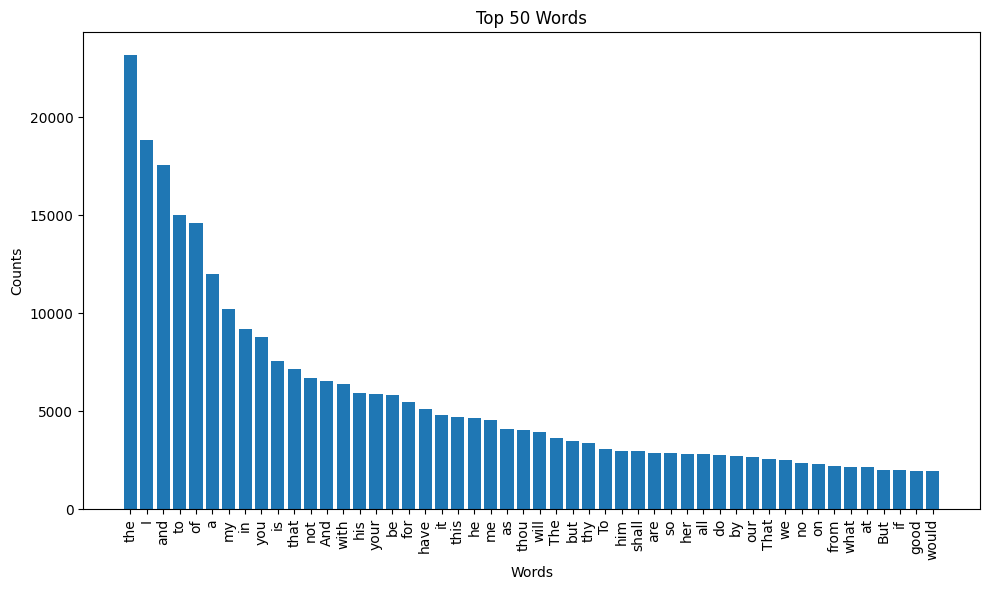

In [145]:
# Function to Generate Word Histogram
def gen_gram(df):
    
    # Concatenate all the Text, Split, and Get Words
    all_text = ' '.join(df.values)
    words = all_text.split()
    word_filt = [word for word in words if word.lower() not in [w.lower() for w in words_to_remove]]

    # Count Occurance
    word_cnt = {}
    for word in word_filt:
        if word not in word_cnt:
            word_cnt[word] = 1
        else:
            word_cnt[word] += 1

    # Sort Words
    word_sort = sorted(word_cnt.items(), key=lambda x: x[1], reverse=True)

    # Get Top 50 Words
    word_top = word_sort[:50]

    # Define Lists
    labels = []
    counts = []
    
    # Get Labels and Count
    for word, count in word_top:
        labels.append(word)
        counts.append(count)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('Top 50 Words')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame([labels, counts])

df_hist = gen_gram(df_unique)

#### Word Count Table

In [146]:
df_hist.head(50)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,the,I,and,to,of,a,my,in,you,is,...,we,no,on,from,what,at,But,if,good,would
1,23187,18834,17597,14998,14621,12021,10215,9185,8798,7560,...,2516,2375,2326,2189,2167,2151,2008,1988,1962,1943


#### Tree Map

Next, is a tree map that is used to give a visualization of the proportions of words to one another.

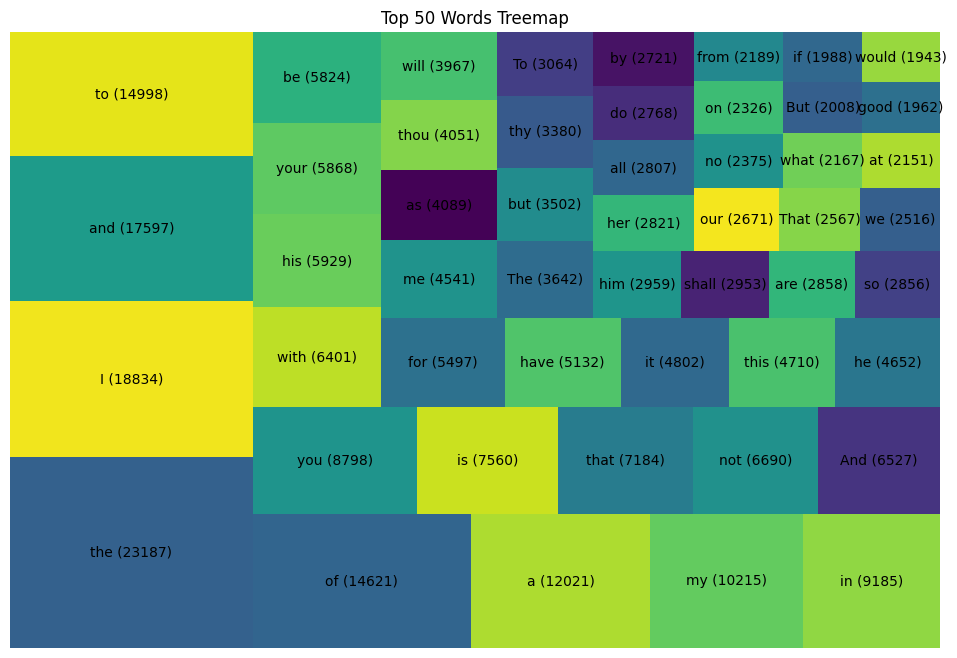

In [147]:
# Function for Tree Map
def create_treemap(df, n=50):
    
    # Concatenate and Split Text
    all_text = ' '.join(df.values)
    words = all_text.split()

    # Count Words
    word_counts = pd.Series(words).value_counts()

    # Select Top Words
    top_words = word_counts.head(n)

    # Normalize
    norm_counts = top_words / top_words.sum()

    # Create labels for the treemap
    labels = [f"{word} ({count})" for word, count in zip(top_words.index, top_words.values)]

    # Generate the treemap
    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=norm_counts.values, label=labels, text_kwargs={'fontsize': 10})
    plt.axis('off')
    plt.title('Top 50 Words Treemap')
    plt.show()

# Create Tree Map
create_treemap(df_unique, n=50)


The most common words are stop words which do not contribute to the sentiment of the text. 

#### Difficulties 

There is an issue with articles, pronouns, and conjunctions being a large part of the data set. This is a natural byproduct of the English language. With more preprocessing and a dictionary of these common filler words, the terms can be removed for a more accurate visualization of word counts specific to the Shakespeare lexicon.|

#### Summary, Discussion, and Findings

Surprisingly, but with hindesight not completely unexpected, the terms that are dominating the word count and tree map are those that are common to the English language. What might be of slight interest is that the term "I" is the second most common placing an importance on the speaker in Shakespearian writing.

#### Conclusions 

In future work, a library which has the most common artifacts of the English language which do not help with finding the specifics of a speaker's language, should be utilized to remove these terms for a more accurate representation of the text's lexicon.

## Results

#### Summary

The following is the RNN with the sample text and evaluation metrics as output. The RNN first converts the characters to integers and vice-versa to map these to mathematical values the layers can process. Next, the input values are cut into sequences that run through the neural net. The RNN is composed of a LSTM model, ReLU dense layer, and a softmax layer. The layer is compiled and ran through multiple hyperparameters such as the epochs and temperature values to produce text and find optimal values. The output text is evaluated through the BLEU and diversity metric. RNN are known for having a specialty in analyzing text being sequential, able to have long-term dependencies, and able to infer information based on values surrounding others. That is why this model was chosen compared to a GAN or CNN. When it comes to model specifics, the values were fine-tuned to input the first 100 lines from the Shakespeare CSV file. Any longer and the code would take too long to run. The batch size was ran and determined to be a multiple of 5 times 128. Originally, this number was 128 and was also changed to have the model produce an output within a reasonable amount of time. 

#### Model

Below is the code to create the model with comments stating what each text block does.

In [148]:
# Declare Training Data Parameters
seq_len = 40
data_X = []
data_y = []

# Load and preprocess the text data
df_RNN = df_unique[:100]
text = ' '.join(df_RNN.values).lower()  

# Create Vocab
chars = sorted(list(set(text)))
num_chars = len(chars)

# Map Char to Int and Int to Char
char_to_int = {char: c1 for c1, char in enumerate(chars)}
int_to_char = {c1: char for c1, char in enumerate(chars)}

# Get Sequence for X and Y
for c1 in range(0, len(text) - seq_len):
    seq_in = text[c1:c1 + seq_len]
    seq_out = text[c1 + seq_len]
    data_X.append([char_to_int[char] for char in seq_in])
    data_y.append(char_to_int[seq_out])

# Normalize and One-hot encode
X = np.reshape(data_X, (len(data_X), seq_len, 1))
X = X / float(num_chars)
y = np.eye(num_chars)[data_y]

# Build RNN model with Multiple Layers
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(256, input_shape=(X.shape[1], X.shape[2])),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_chars, activation='softmax')
])

# Compile the Model, loss Selected Based On Single Class and Optimizer Because Text Input
model.compile(loss='categorical_crossentropy', optimizer='adam')

Next is the function that is used to generate text from the model as well as calculate diversity metrics and the BLEU score.

In [149]:
# Function for Text Generation
def generate_text(epoch, temp):
    
    # Function to Get Next Character
    def next_char_func(pred, temp):
        pred = np.asarray(pred).astype('float64')
        pred = np.log(pred) / temp
        exp_preds = np.exp(pred)
        pred = exp_preds / np.sum(exp_preds)
        prob = np.random.multinomial(1, pred, 1)
        return np.argmax(prob)

    # Generate Characters
    if epoch % 2 == 0:
        start_index = np.random.randint(0, len(data_X) - seq_len - 1)
        text_gen = text[start_index:start_index + seq_len]
        text_out = text_gen

        # Create Characters
        for c1 in range(40):
            x = np.reshape([char_to_int[char] for char in text_gen], (1, seq_len, 1))
            x = x / float(num_chars)
            pred = model.predict(x, verbose=0)[0]
            next_index = next_char_func(pred, temp)
            next_char = int_to_char[next_index]
            text_out += next_char
            text_gen = text_gen[1:] + next_char
            
        print()
        print(text_out)

        # Get Diversity Metrics Function
        def div_met(text):
            tkns = nltk.word_tokenize(text)
            tkns_cnt = nltk.FreqDist(tkns)
            total_count = len(tkns)
            prob = [count / total_count for count in tkns_cnt.values()]
            entropy = -np.sum([p * np.log2(p) for p in prob])
            diversity_metric = 1 / (entropy + 1e-7)  
            return diversity_metric

        # Calculate BLEU score
        ref = [text_gen.split()]  
        cand = text_out.split()  
        bleu_score = sentence_bleu(ref, cand)
        print("BLEU score:", bleu_score)

        # Calculate diversity metric
        diversity = div_met(' '.join(cand))
        print("Diversity metric:", diversity)

Finally, here is where the code generates an ouput using temperature as an adjustable input.

In [150]:
for temp in [0.5, 1]:
    print("Temperature Value:", temp)
    text_generation_callback = LambdaCallback(on_epoch_end=lambda epoch, logs: generate_text(epoch, temp))
    model.fit(X, y, epochs=10, batch_size=128*5, callbacks=[text_generation_callback])
    print()

Temperature Value: 0.5
Epoch 1/10
7/7 [==============================] - ETA: 0s - loss: 3.4251
, and breathe short-winded accents of ne   s      n wn   n n  :  est    h    :qi
BLEU score: 0.5129497107827519
Diversity metric: 0.2709941456137781
7/7 [==============================] - 24s 3s/step - loss: 3.4251
Epoch 2/10
7/7 [==============================] - 14s 2s/step - loss: 3.0931
Epoch 3/10
7/7 [==============================] - ETA: 0s - loss: 2.9912
ld, that ever-valiant and approved scot, t e   ie  t  rehrn nrslndell  i  lee t 
BLEU score: 0.5512003357447272
Diversity metric: 0.2709941456137781
7/7 [==============================] - 19s 3s/step - loss: 2.9912
Epoch 4/10
7/7 [==============================] - 14s 2s/step - loss: 2.9477
Epoch 5/10
7/7 [==============================] - ETA: 0s - loss: 2.9280
 in cradle-clothes our children where th t t  e   llia esteenrdhe   emn ef  e e 
BLEU score: 0.5512003357447272
Diversity metric: 0.28930456678411803
7/7 [===================

#### Summary

The model is able to produce text that isn't as coherent as regular text. There are several reasons why this might be: the data might be cluttered due to the prevalance of the articles, conjunctions, pronouns, and other artifacts that are signature of the English language, more layers need to be added, a higher epoch number, smaller batch size, or a different model should be used. There are multiple areas that can be fine-tuned when it comes to producing a more high quality Shakespeare text generator.

#### Evaluation Metrics

With more epocs, the BLEU score slightly rises which means that the generated text is looks more human. The BLEU score is also higher when the temperature is set at 0.5. As for the diversity metric, this remains the same with each evaluation regardless of the number of epochs or temperature. These are both areas of improvement that is addressed in the Future Improvement Opportunities Section.

#### Model Comparison

Since the BLEAU score seemed to max out at approximately 0.50, this meant that more epochs weren't necessary. Thus, the model could be stopped around approximately 5 epochs in this case. As for the diversity metric, the epoch value was found to have no effect. When it comes to temperature, a lower value was shown to have a higher BLEU score. This means that the temperature should be 0.5 or perhaps lower.

## Discussion and Conclusion

#### Lessons Learned

The data set was also not resized earlier and having problems running through the RNN which took a large amount of time to rectify. Thus, dimensions would be evaluated and fine-tuned before the rest of the model. Before breaking up the code into multiple functions, the RNN was in an entire block which made debugging difficult. Thus, if this project were done again, sectioning the code would be implemented first. Before settling on Shakespeare, images of Pokemon were consulted as a part of a CNN. This was deemed to be too complicated  and thus text was settled on.  

#### Mistakes

The epochs, batch size, and training set were originally set to time-consuming values and the model had trouble compiling within an adequate time frame. 

#### Future Improvement Opportunities

With more devices or computers available, a smaller batch size, larger epoch count, more layers, and more of the data frame (instead of the first 100 rows) could be used to evaluate the model. There would also be an opportunity to test the addition of more intermediate layers to the model and with more hyperparameters.  

## APA Citations
[1] Larsen, Liam. (2017 June 22). Shakespeare Plays. Kaggle. https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays